##Downloading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/Colab_Notebooks/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d chiragsoni/ferdata

Dataset URL: https://www.kaggle.com/datasets/chiragsoni/ferdata
License(s): CC0-1.0
 94% 57.0M/60.3M [00:03<00:00, 17.3MB/s]
100% 60.3M/60.3M [00:03<00:00, 20.3MB/s]


In [ ]:
!unzip /content/ferdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

#Importing the Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage.io import imread
from skimage.transform import rescale
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from keras.layers import Input, UpSampling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, InceptionV3, MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.preprocessing import image
import os
sns.set()

#Loading the Dataset

##Loading Training Data

In [ ]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/train",
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical',
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

##Loading Test Dataset

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/test",
                                           target_size=(128,128),
                                           batch_size=32,
                                           class_mode='categorical',
                                  )

val_data.class_indices

Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

#Visualization of Emotion Category Distribution in Training Data

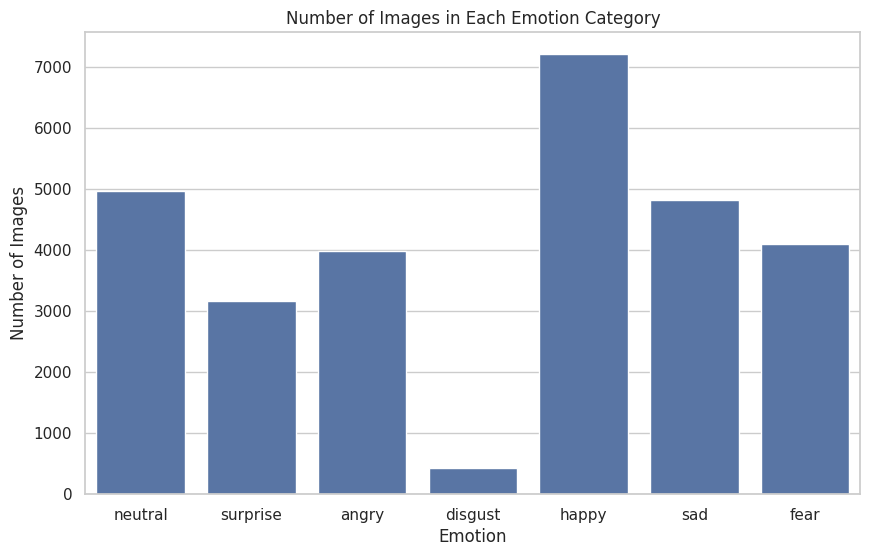

In [ ]:
path = '/content/train'

emotions = os.listdir(path)

folder_names = []
counts = []

for emotion in emotions:
    emotion_path = os.path.join(path, emotion)
    num_images = len(os.listdir(emotion_path))

    folder_names.append(emotion)
    counts.append(num_images)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=folder_names, y=counts)
ax.set(xlabel='Emotion', ylabel='Number of Images')
plt.title('Number of Images in Each Emotion Category')
plt.show()

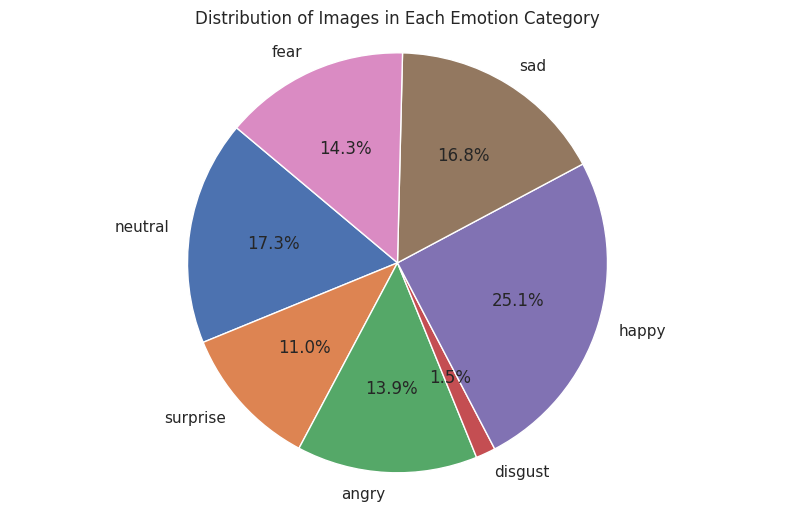

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(counts, labels=folder_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images in Each Emotion Category')
plt.axis('equal')
plt.show()

#Visualization of Sample Images from Training Data

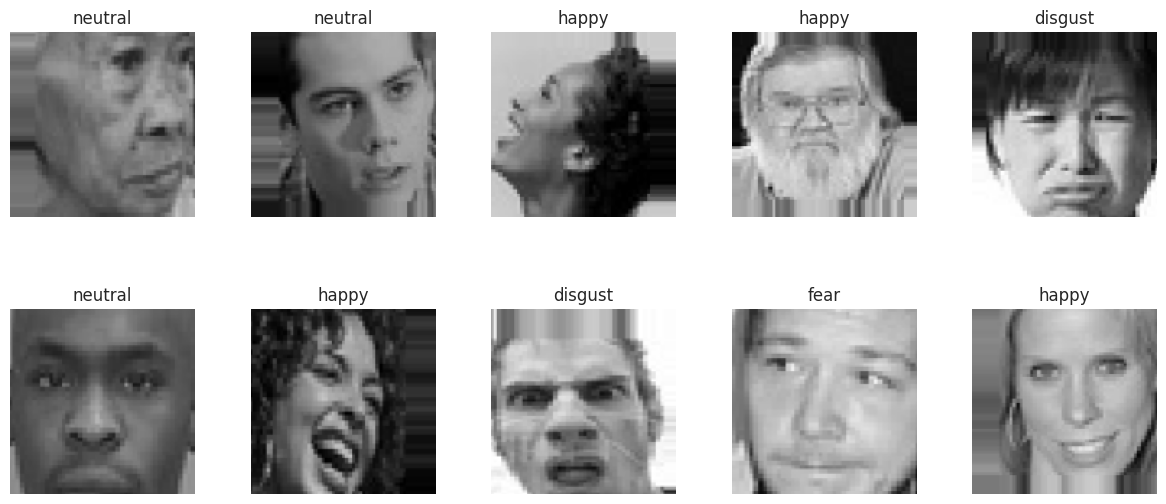

In [ ]:
t_img , label = next(train_data)

def plotImages(img_arr, one_hot_labels, label_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.5)

    for i, (im, one_hot_label) in enumerate(zip(img_arr, one_hot_labels)):
        label_index = np.argmax(one_hot_label)
        label_name = label_names[label_index]

        ax = axes[i // 5, i % 5]
        ax.imshow(im)
        ax.set_title(label_name)
        ax.axis('off')

        if i == 9:
            break

label_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plotImages(t_img, label, label_names)

#Deep Learning

## Traansfer Learning(TL)

###MobileNet-based CNN Model

In [ ]:
base_model = MobileNet( weights = 'imagenet', input_shape = (128,128,3), include_top = False )

x = base_model.output
x= Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(units = 256 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units = 512 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units=7 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)

model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy']  )
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,095,847 (19.44 MB)

 Trainable params: 5,073,959 (19.36 MB)

 Non-trainable params: 21,888 (85.50 KB)

###Model Training with Callbacks

In [ ]:
checkpoint = ModelCheckpoint(filepath="best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:
hist = model.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list, verbose=2)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.46712, saving model to best_model.keras
898/898 - 200s - 223ms/step - accuracy: 0.4046 - loss: 1.4966 - val_accuracy: 0.4671 - val_loss: 1.4716 - learning_rate: 0.0010
Epoch 2/25

Epoch 2: val_accuracy improved from 0.46712 to 0.53566, saving model to best_model.keras
898/898 - 162s - 181ms/step - accuracy: 0.4952 - loss: 1.3162 - val_accuracy: 0.5357 - val_loss: 1.2111 - learning_rate: 0.0010
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.53566
898/898 - 144s - 160ms/step - accuracy: 0.5430 - loss: 1.2235 - val_accuracy: 0.5311 - val_loss: 1.2580 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: val_accuracy improved from 0.53566 to 0.56395, saving model to best_model.keras
898/898 - 146s - 163ms/step - accuracy: 0.5687 - loss: 1.1641 - val_accuracy: 0.5639 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 5/25

Epoch 5: val_accuracy improved from 0.56395 to 0.56464, saving model to best_model.keras
898/898 - 147s - 164ms/step - accur

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection.keras')
model = load_model('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection.h5')

###Training and Validation Metrics Visualization

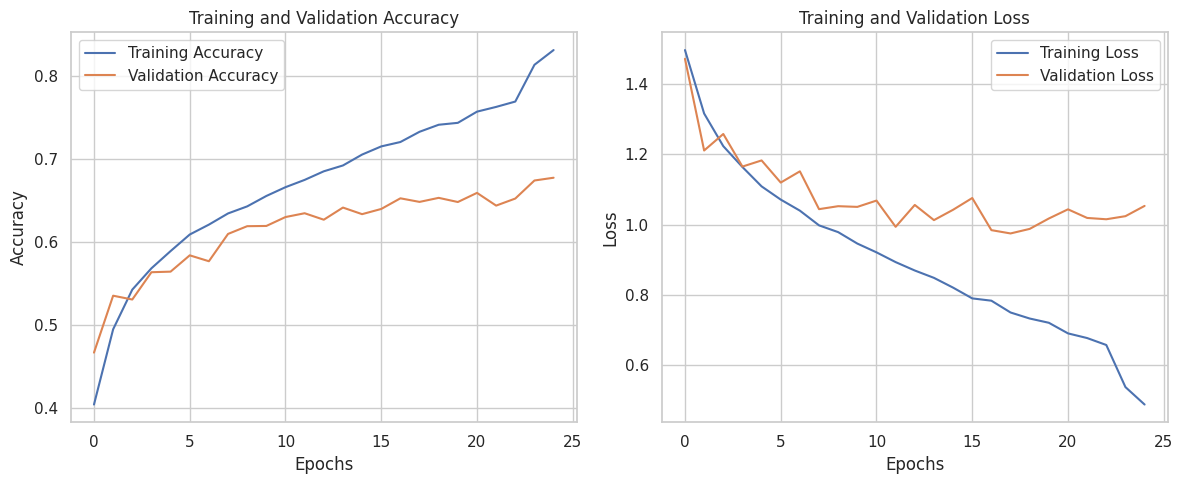

In [ ]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation of the Model

In [ ]:
results = model.evaluate(val_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6792 - loss: 1.0257
Test results - Loss: 1.02 - Accuracy: 67.44%


###Model Prediction on Test Images

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
/content/test/neutral/PrivateTest_11239107.jpg 
The image is of neutral.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/test/disgust/PrivateTest_89077668.jpg 
The image is of disgust.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/test/angry/PrivateTest_10590091.jpg 
The image is of angry.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/test/fear/PrivateTest_1161501.jpg 
The image is of angry.



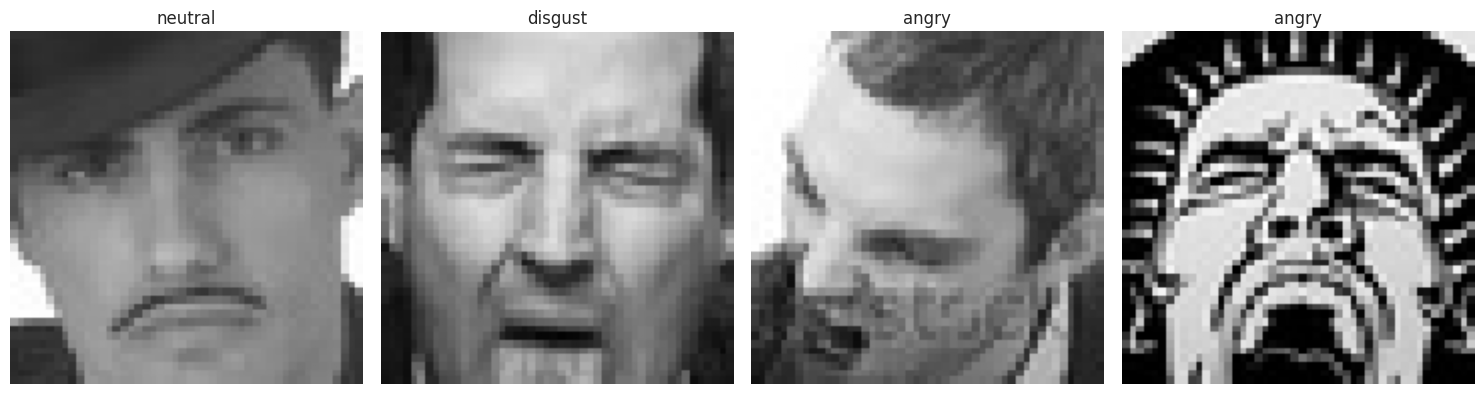

In [ ]:
image_paths = [
    '/content/test/neutral/PrivateTest_11239107.jpg',
    '/content/test/disgust/PrivateTest_89077668.jpg',
    '/content/test/angry/PrivateTest_10590091.jpg',
    '/content/test/fear/PrivateTest_1161501.jpg'
]

num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, path in enumerate(image_paths):
    img = load_img(path, target_size=(128, 128))
    img_arr = img_to_array(img) / 255
    input_arr = np.array([img_arr])
    pred = np.argmax(model.predict(input_arr))
    print(f"{path} \nThe image is of {op[pred]}.\n")

    axs[i].imshow(img_arr)
    axs[i].set_title(op[pred])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

##Convolutional Neural Network (CNN)

###CNN Model

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters = 128, kernel_size = (1,1), input_shape = [128,128,3]))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 256, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 512, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Flatten())

model_cnn.add(Dense(units = 256))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 512))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 1024))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 7, activation = 'softmax'))

model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 29, 29, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,830,279 (106.16 MB)

 Trainable params: 27,830,279 (106.16 MB)

 Non-trainable params: 0 (0.00 B)

###Model Training with Callbacks

In [ ]:
hist_cnn = model_cnn.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list, verbose=2)

Epoch 1/25

Epoch 1: val_accuracy did not improve from 0.67777
898/898 - 178s - 198ms/step - accuracy: 0.2566 - loss: 1.8022 - val_accuracy: 0.2999 - val_loss: 1.7233 - learning_rate: 0.0010
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.67777
898/898 - 161s - 180ms/step - accuracy: 0.3023 - loss: 1.7150 - val_accuracy: 0.3598 - val_loss: 1.6052 - learning_rate: 0.0010
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.67777
898/898 - 159s - 177ms/step - accuracy: 0.3553 - loss: 1.6246 - val_accuracy: 0.4164 - val_loss: 1.5002 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.67777
898/898 - 158s - 176ms/step - accuracy: 0.3940 - loss: 1.5428 - val_accuracy: 0.4285 - val_loss: 1.4697 - learning_rate: 0.0010
Epoch 5/25

Epoch 5: val_accuracy did not improve from 0.67777
898/898 - 203s - 226ms/step - accuracy: 0.4249 - loss: 1.4748 - val_accuracy: 0.4668 - val_loss: 1.3892 - learning_rate: 0.0010
Epoch 6/25

Epoch 6: val_accuracy did not imp

###Training and Validation Metrics Visualization

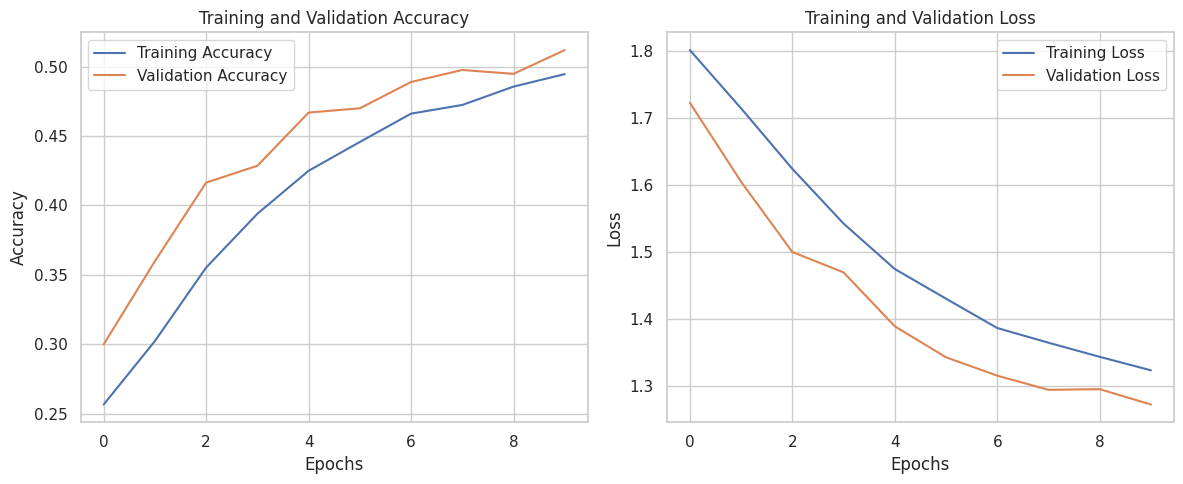

In [ ]:
train_acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']
train_loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation of the Model on Validation Data

In [ ]:
results = model_cnn.evaluate(val_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3007 - loss: 1.7145
Test results - Loss: 1.72 - Accuracy: 29.99%


###Model Prediction on Test Images

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
/content/test/neutral/PrivateTest_11239107.jpg 
The image is of happy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/test/disgust/PrivateTest_89077668.jpg 
The image is of surprise.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/test/angry/PrivateTest_10590091.jpg 
The image is of happy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/test/fear/PrivateTest_1161501.jpg 
The image is of sad.



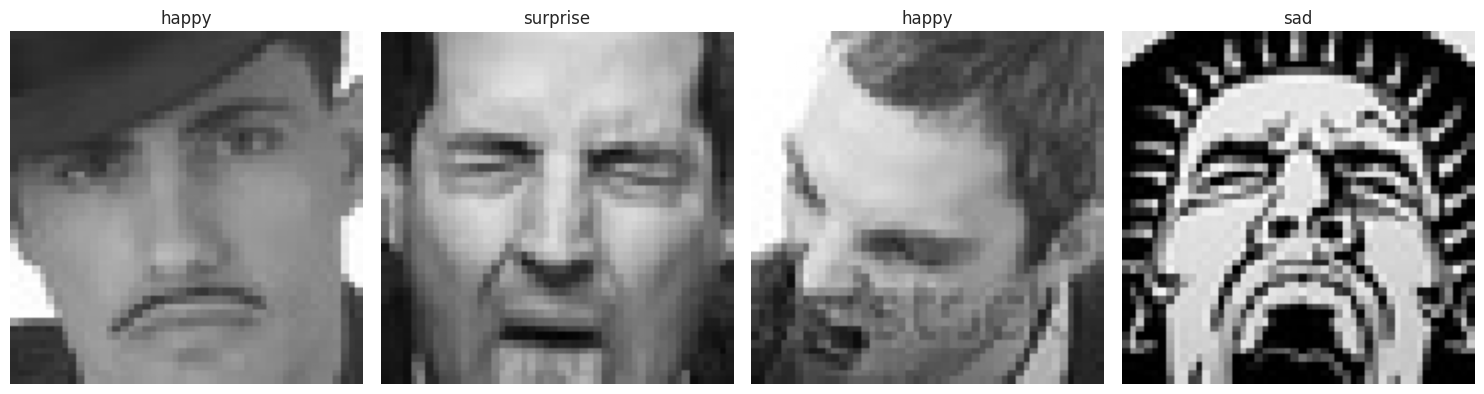

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

image_paths = [
    '/content/test/neutral/PrivateTest_11239107.jpg',
    '/content/test/disgust/PrivateTest_89077668.jpg',
    '/content/test/angry/PrivateTest_10590091.jpg',
    '/content/test/fear/PrivateTest_1161501.jpg'
]

num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, path in enumerate(image_paths):
    img = load_img(path, target_size=(128, 128))
    img_arr = img_to_array(img) / 255
    input_arr = np.array([img_arr])
    pred = np.argmax(model_cnn.predict(input_arr))
    print(f"{path} \nThe image is of {op[pred]}.\n")

    axs[i].imshow(img_arr)
    axs[i].set_title(op[pred])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model_cnn.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection_cnn.keras')
# model_cnn = load_model('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection.h5')